<a href="https://colab.research.google.com/github/arisnbrio/covid-19-country-infection-levels/blob/main/classification_infection_levels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np

epid = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", parse_dates = True) 
# deceased, deaths, recover etc
demo = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv")
# population
ind = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/index.csv") 
# needed for country/country code/subregion1_code(city)
data = pd.merge(pd.merge(epid, demo, on = 'key'), ind, on = 'key')  # join by key 

# add column new confirm vs total confirm | add column total confirmed cases vs population
data = data.assign(nconfirmed_tconfirmed = lambda x: data['new_confirmed'] 
                               / data['total_confirmed']).assign(confirmed_pop = lambda x: data['total_confirmed'] 
                               / data['population'])

cases_per_1M = data['new_confirmed']/data['population'] # cases per 1 million pop
cases_per_1M = cases_per_1M.apply(lambda x: x*1000000)
data = data.assign(cases_per_1M = cases_per_1M) # create new column cases_per_1M


KeyboardInterrupt: ignored

In [60]:
#data.describe()
#data.info()
data.head()
data.info
# number of days of observations we have for each country
num_days = data['date'].unique()
num_days.shape

(696,)

## Sampled dataset for the months of January and February 2021

In [61]:
country_data = data[data['subregion1_code'].isnull()] # collect rows that don't specify subregions
country_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] <= '2021-02-28')] # filter dates between jan and feb
country_data = country_data.drop(['subregion1_code','subregion1_name','subregion2_code','subregion2_name'], axis=1) # drop column
country_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 13632 entries, 367 to 1576232
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         13632 non-null  object 
 1   key                          13573 non-null  object 
 2   new_confirmed                13624 non-null  float64
 3   new_deceased                 13594 non-null  float64
 4   new_recovered                990 non-null    float64
 5   new_tested                   5569 non-null   float64
 6   total_confirmed              13624 non-null  float64
 7   total_deceased               13594 non-null  float64
 8   total_recovered              909 non-null    float64
 9   total_tested                 5537 non-null   float64
 10  population                   13632 non-null  float64
 11  population_male              13455 non-null  float64
 12  population_female            13455 non-null  float64
 13  rural_popula

## Split into Months
Using January data as our training, and February data as our test

In [62]:
jan_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] < '2021-02-01')]

jan_data = jan_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # mean of total new cases in that week per 1M ppl
        'new_confirmed':['mean'],   # cumulative number of cases over the past 59 days 
        'total_confirmed': ['mean'], #  mean of total cases of that week
        'confirmed_pop': ['mean'],
        'population': ['mean'],
        'new_deceased': ['mean'],
        'total_deceased': ['max']
    }
).reset_index()



conditions = [  # if else basically
    (jan_data['cases_per_1M'] < 500), # level 1
    (jan_data['cases_per_1M'] >= 500) & (jan_data['cases_per_1M'] < 1000), # level 2
    (jan_data['cases_per_1M'] >=  1000) # level 3
    ]
values = [1, 2, 3]

## true labels for our training data
jan_data['levels'] = np.select(conditions, values)

jan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (country_name, )         231 non-null    object 
 1   (cases_per_1M, sum)      231 non-null    float64
 2   (new_confirmed, mean)    231 non-null    float64
 3   (total_confirmed, mean)  231 non-null    float64
 4   (confirmed_pop, mean)    231 non-null    float64
 5   (population, mean)       231 non-null    float64
 6   (new_deceased, mean)     231 non-null    float64
 7   (total_deceased, max)    231 non-null    float64
 8   (levels, )               231 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 16.4+ KB


In [63]:
jan_data = jan_data.set_index(['country_name'])

In [67]:
feb_data = country_data[(country_data['date'] >= '2021-02-01') & (country_data['date'] <= '2021-02-28')]

feb_data = feb_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # mean of total new cases in that week per 1M ppl
        'new_confirmed':['mean'],   # cumulative number of cases over the past 59 days 
        'total_confirmed': ['mean'], #  mean of total cases of that week
        'confirmed_pop': ['mean'],
        'population': ['mean'],
        'new_deceased': ['mean'],
        'total_deceased': ['max']
    }
).reset_index()


conditions = [  # if else basically
    (feb_data['cases_per_1M'] < 500), # level 1
    (feb_data['cases_per_1M'] >= 500) & (feb_data['cases_per_1M'] < 1000), # level 2
    (feb_data['cases_per_1M'] >=  1000) # level 3
    ]
values = [1, 2, 3]

## true labels for our testing data 
feb_data['levels'] = np.select(conditions, values)

feb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (country_name, )         230 non-null    object 
 1   (cases_per_1M, sum)      230 non-null    float64
 2   (new_confirmed, mean)    230 non-null    float64
 3   (total_confirmed, mean)  230 non-null    float64
 4   (confirmed_pop, mean)    230 non-null    float64
 5   (population, mean)       230 non-null    float64
 6   (new_deceased, mean)     229 non-null    float64
 7   (total_deceased, max)    229 non-null    float64
 8   (levels, )               230 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 16.3+ KB


In [68]:
feb_data = feb_data.set_index(['country_name'])

In [69]:
country_data_sum = country_data.groupby( # grouping by country (takes into account all dates between jan and feb instead of by week)
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # mean of total new cases in that week per 1M ppl
        'new_confirmed':['mean'],   # cumulative number of cases over the past 59 days 
        'total_confirmed': ['mean'], #  mean of total cases of that week
        'nconfirmed_tconfirmed': ['mean'], # mean
        'confirmed_pop': ['mean'],
        'population': ['mean'],
        'new_deceased': ['mean'],
        'total_deceased': ['max'],
        'new_tested':	['mean'],
        'total_tested': ['max'],
    }
).reset_index()
# these numbers represent the entire 2 months we've filtered

conditions = [ # if else basically
    (country_data_sum['cases_per_1M'] < 500),
    (country_data_sum['cases_per_1M'] >= 500) & (country_data_sum['cases_per_1M'] < 1000),
    (country_data_sum['cases_per_1M'] >=  1000)
    ]
values = [1, 2, 3] # levels

country_data_sum['levels'] = np.select(conditions, values) # creates column for df

# similar to CDC, cases over january and february per 1M population put into levels

country_data_sum.info()

country_data_sum.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   (country_name, )               231 non-null    object 
 1   (cases_per_1M, sum)            231 non-null    float64
 2   (new_confirmed, mean)          231 non-null    float64
 3   (total_confirmed, mean)        231 non-null    float64
 4   (nconfirmed_tconfirmed, mean)  218 non-null    float64
 5   (confirmed_pop, mean)          231 non-null    float64
 6   (population, mean)             231 non-null    float64
 7   (new_deceased, mean)           231 non-null    float64
 8   (total_deceased, max)          231 non-null    float64
 9   (new_tested, mean)             106 non-null    float64
 10  (total_tested, max)            110 non-null    float64
 11  (levels, )                     231 non-null    int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 

,country_name,cases_per_1M,new_confirmed,total_confirmed,nconfirmed_tconfirmed,confirmed_pop,population,new_deceased,total_deceased,new_tested,total_tested,levels
,,sum,mean,mean,mean,mean,mean,mean,max,mean,max,
0,Afghanistan,81.50874,53.77966,54757.28814,0.00099,0.00141,38928341.00000,3.98305,2446.00000,nan,nan,1
1,Albania,17191.00609,834.03390,80483.94915,0.01026,0.02812,2862427.00000,10.67797,1816.00000,3469.80702,447163.00000,3
2,Algeria,307.44993,228.50847,107117.06780,0.00215,0.00244,43851043.00000,3.84746,2983.00000,nan,nan,1
3,American Samoa,0.00000,0.00000,0.00000,nan,0.00000,55196.00000,0.00000,0.00000,nan,nan,1
4,Andorra,35876.52883,46.98305,9754.64407,0.00496,0.12625,77265.00000,0.44068,110.00000,nan,157356.00000,3


## Construct our Response Variable: Each countries labels (overall for january and february)

In [70]:
response_var = country_data_sum[['levels']].copy() # new dataframe containing only the 'levels' column, indexed by country 
response_var

,levels
,
0,1
1,3
2,1
3,1
4,3
...,...
226,1
227,1
228,1


In [71]:
response_var.value_counts()

(levels, )
3             132
1              86
2              13
dtype: int64

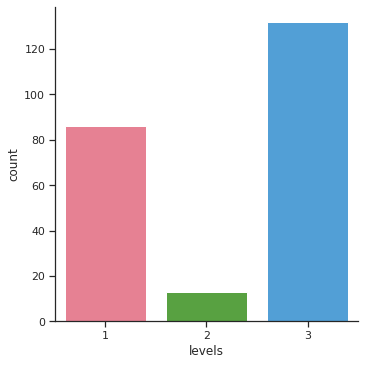

In [72]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.color_palette("husl", 3)
g = sns.catplot(x = "levels", kind = "count", palette = "husl", data = response_var, order = [1, 2, 3])

In [73]:
train_X = jan_data.drop(['levels'], axis = 1)
train_X

,cases_per_1M,new_confirmed,total_confirmed,confirmed_pop,population,new_deceased,total_deceased
,sum,mean,mean,mean,mean,mean,max
country_name,,,,,,,
Afghanistan,65.11965,81.77419,54075.48387,0.00139,38928341.00000,6.25806,2405.00000
Albania,7081.05394,653.83871,68027.06452,0.02377,2862427.00000,6.67742,1393.00000
Algeria,181.70605,257.03226,103804.64516,0.00237,43851043.00000,4.45161,2894.00000
American Samoa,0.00000,0.00000,0.00000,0.00000,55196.00000,0.00000,0.00000
Andorra,24008.28318,59.83871,9070.80645,0.11740,77265.00000,0.54839,101.00000
...,...,...,...,...,...,...,...
Vietnam,3.87308,12.16129,1565.61290,0.00002,97338583.00000,0.00000,35.00000
Wallis and Futuna,88.92841,0.03226,4.25806,0.00038,11245.00000,0.00000,0.00000


In [74]:
train_Y = jan_data['levels']
train_Y

country_name
Afghanistan          1
Albania              3
Algeria              1
American Samoa       1
Andorra              3
                    ..
Vietnam              1
Wallis and Futuna    1
Yemen                1
Zambia               3
Zimbabwe             3
Name: levels, Length: 231, dtype: int64

In [75]:
test_X = feb_data.drop(['levels'],axis = 1).fillna(0)
test_X

,cases_per_1M,new_confirmed,total_confirmed,confirmed_pop,population,new_deceased,total_deceased
,sum,mean,mean,mean,mean,mean,max
country_name,,,,,,,
Afghanistan,16.38909,22.78571,55512.14286,0.00143,38928341.00000,1.46429,2446.00000
Albania,10109.95215,1033.53571,94275.50000,0.03294,2862427.00000,15.10714,1816.00000
Algeria,125.74387,196.92857,110784.39286,0.00253,43851043.00000,3.17857,2983.00000
American Samoa,0.00000,0.00000,0.00000,0.00000,55196.00000,0.00000,0.00000
Andorra,11868.24565,32.75000,10511.75000,0.13605,77265.00000,0.32143,110.00000
...,...,...,...,...,...,...,...
Vietnam,6.37979,22.17857,2231.42857,0.00002,97338583.00000,0.00000,35.00000
Wallis and Futuna,355.71365,0.14286,8.14286,0.00072,11245.00000,0.00000,0.00000


In [76]:
test_Y = feb_data['levels']
test_Y

country_name
Afghanistan          1
Albania              3
Algeria              1
American Samoa       1
Andorra              3
                    ..
Vietnam              1
Wallis and Futuna    1
Yemen                1
Zambia               3
Zimbabwe             1
Name: levels, Length: 230, dtype: int64

## Oversampling

Since there is class imbalance especially among level 2, we use the SMOTEEN package to oversample.

In [77]:
from collections import Counter
from imblearn.combine import SMOTEENN

In [94]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = train_X.columns
os_data_X,os_data_y=os.fit_sample(train_X, train_Y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['levels'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of countries level 1 in oversampled data",len(os_data_y[os_data_y['levels']==1]))
print("Number of countries level 2 in oversampled data",len(os_data_y[os_data_y['levels']==2]))
print("Number of countries level 3 in oversampled data",len(os_data_y[os_data_y['levels']==3]))

length of oversampled data is  354
Number of countries level 1 in oversampled data 118
Number of countries level 2 in oversampled data 118
Number of countries level 3 in oversampled data 118


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## OVR Logistic Regression

Regular Logistic Regression is for binary responses which is why we opt for different variants of logistic regression for multi-classification.



In [95]:
from sklearn.linear_model import LogisticRegression
logmod_ovr = LogisticRegression(multi_class='ovr').fit(os_data_X, os_data_y)
logy_pred = logmod_ovr.predict(test_X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [96]:
print(logmod_ovr.score(os_data_X, os_data_y))

0.8983050847457628


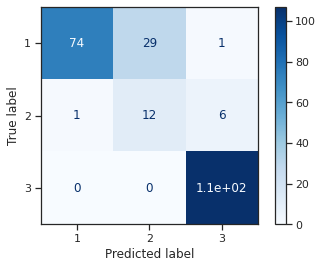

In [97]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


levels = ['1','2','3']
ovrdisp = plot_confusion_matrix(logmod_ovr, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

In [98]:
import sklearn.metrics as metrics
print(metrics.classification_report(test_Y, logmod_ovr.predict(test_X)))

              precision    recall  f1-score   support

           1       0.99      0.71      0.83       104
           2       0.29      0.63      0.40        19
           3       0.94      1.00      0.97       107

    accuracy                           0.84       230
   macro avg       0.74      0.78      0.73       230
weighted avg       0.91      0.84      0.86       230



In [99]:
accuracy_score(test_Y, logy_pred)

0.8391304347826087

## Multinomial Logistic Regression

In [83]:
logmod_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs').fit(os_data_X, os_data_y)
print('Accuracy: %1.4f\n' % (logmod_multi.score(test_X, test_Y)))

Accuracy: 0.8435



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
logmod_multi.score(test_X, test_Y)

0.8434782608695652

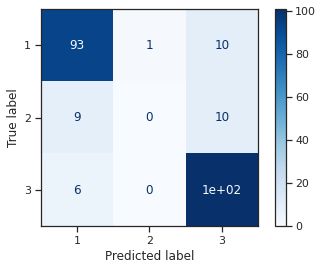

In [85]:
multidisp = plot_confusion_matrix(logmod_multi, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

In [86]:
print(metrics.classification_report(test_Y, logmod_multi.predict(test_X)))

              precision    recall  f1-score   support

           1       0.86      0.89      0.88       104
           2       0.00      0.00      0.00        19
           3       0.83      0.94      0.89       107

    accuracy                           0.84       230
   macro avg       0.57      0.61      0.59       230
weighted avg       0.78      0.84      0.81       230



In [87]:
accuracy_score(test_Y, logmod_multi.predict(test_X))

0.8434782608695652

OVR Logistic Regression gives the best classification report, matrix, and overall accuracy compared to Multionomial Logistic Regression.

# SVM

In [ ]:
import pandas as pd
from sklearn.svm import SVC

test_x = pd.read_csv('/content/test_x.csv')
train_x = pd.read_csv('/content/train_x.csv')
test_y = pd.read_csv('/content/test_y.csv')
train_y = pd.read_csv('/content/train_y.csv')

#remove the extra cols and change the datafrmae to a matrix
x = train_x.drop(['id','country_name'],axis = 1)
x = x.values.reshape(-1,7)
y = train_y['levels']
y = y.values

#reduce sample
x = x[1:20]
y = y[1:20]

#fit the model
model = SVC(kernel='linear', C=1E10)
model.fit(x,y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
from sklearn.metrics import accuracy_score

x_test = test_x.drop(['id','country_name'],axis = 1)
x_test = x_test.values.reshape(-1,7)
y_test = test_y['levels']
y_test = y_test.values

predict = model.predict(x_test)
accurate = accuracy_score(y_test,predict,normalize=False)
#model.score(x_test,y_test)
accuracy_score(y_test,predict)

0.8095238095238095

In [ ]:
#SVM with reduced variable

x = train_x.drop(['id','country_name','population mean'],axis = 1)
x = x.values.reshape(-1,6)
y = train_y['levels']
y = y.values

model = SVC(kernel='linear', C=1E10)
model.fit(x,y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
x_test = test_x.drop(['id','country_name','population mean'],axis = 1)
x_test = x_test.values.reshape(-1,6)
y_test = test_y['levels']
y_test = y_test.values

predict = model.predict(x_test)
accurate = accuracy_score(y_test,predict,normalize=False)
#model.score(x_test,y_test)
accuracy_score(y_test,predict)

0.974025974025974

# Naive Bayes Classifier - Gaussian

In [ ]:
from sklearn.naive_bayes import GaussianNB
gNB = GaussianNB()
gNB_train = gNB.fit(os_data_X, os_data_y)
gNB_pred = gNB_train.predict(test_X)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.metrics import accuracy_score
# Classification accuracy on the training data
print('Classification Accuracy on training set:', gNB_train.score(os_data_X, os_data_y))
# Classification accuracy on the testing data 
print('Classification Accuracy on testing set:', accuracy_score(test_Y, gNB_pred))

Classification Accuracy on training set: 0.423728813559322
Classification Accuracy on testing set: 0.21212121212121213


# Naive Bayes Classifier - Multinomial

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mNB = MultinomialNB() # multinomial naive bayes classifier for multiclass classification 
mNB_train = mNB.fit(os_data_X, os_data_y)
mNB_pred = mNB_train.predict(test_X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Classification accuracy on the training data
print('Classification Accuracy on training set:', mNB_train.score(os_data_X, os_data_y))
# Classification accuracy on the testing data 
print('Classification Accuracy on testing set:', accuracy_score(test_Y, mNB_pred))

Classification Accuracy on training set: 0.7146892655367232
Classification Accuracy on testing set: 0.7965367965367965
